In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [5]:
normal_df=pd.read_csv('/content/drive/MyDrive/CANIDS/Data/normal_run_data.csv')
normal_df['label']='R'
normal_df=normal_df.drop(columns=['DLC', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8'])

DoS_df=pd.read_csv('/content/drive/MyDrive/CANIDS/Data/DoS_dataset.csv')
DoS_df=pd.concat([DoS_df.iloc[:,0:2],DoS_df.iloc[:,-1]],axis=1)
DoS_df.columns=['Timestamp','ID','label']
DoS_df.head()

,Timestamp,ID,label
0,1.478198e+09,018f,R
1,1.478198e+09,0260,R
2,1.478198e+09,02a0,R
3,1.478198e+09,0329,R
4,1.478198e+09,0545,R


In [6]:
def h2i(s):
    return int(s,16)

def d2t(s):
  return pd.Timestamp(s,unit="s")

def s2i(s):
    if s=='R':
      return 0
    else:
      return 1

In [7]:
normal_df['ID']=normal_df['ID'].apply(h2i)
DoS_df['ID']=DoS_df['ID'].apply(h2i)
normal_df['Timestamp']=normal_df['Timestamp'].apply(d2t)
DoS_df['Timestamp']=DoS_df['Timestamp'].apply(d2t)

In [8]:
normal_df.head()

,Timestamp,ID,label
0,2016-11-14 11:03:54.850202084,848,R
1,2016-11-14 11:03:54.850423098,704,R
2,2016-11-14 11:03:54.850976944,1072,R
3,2016-11-14 11:03:54.851214886,1201,R
4,2016-11-14 11:03:54.851463079,497,R


In [9]:
normal_df.shape

(988742, 3)

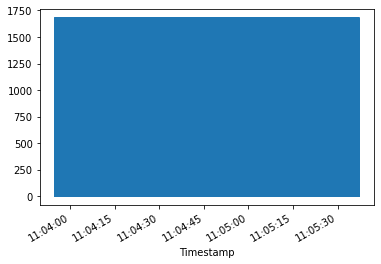

In [10]:
plot_features = normal_df['ID'][0:200000]
plot_features.index = normal_df['Timestamp'][0:200000]
_ = plot_features.plot(subplots=True)

In [11]:
normal_df.shape,DoS_df.shape
train=normal_df
test=DoS_df

# Time step 20

In [37]:
TIME_STEPS=20

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):

        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

In [38]:
X_train, y_train = create_sequences(train[['ID']][:200000], train['ID'][:200000])
print(f'Training shape: {X_train.shape}')

Training shape: (199980, 20, 1)


In [39]:
X_test, y_test = create_sequences(test[['ID']], test['ID'])
print(f'Testing shape: {X_test.shape}')

Testing shape: (3665750, 20, 1)


In [40]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_3 (RepeatVect  (None, 20, 128)          0         
 or)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 20, 128)           131584    
                                                                 
 dropout_7 (Dropout)         (None, 20, 128)           0         
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1)            129       
 tributed)                                            

In [41]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
5625/5625 [==============================] - 42s 7ms/step - loss: 447.6454 - val_loss: 317.4622
Epoch 2/100
5625/5625 [==============================] - 38s 7ms/step - loss: 303.5652 - val_loss: 300.4792
Epoch 3/100
5625/5625 [==============================] - 38s 7ms/step - loss: 302.1971 - val_loss: 300.4815
Epoch 4/100
5625/5625 [==============================] - 38s 7ms/step - loss: 302.1884 - val_loss: 300.4817
Epoch 5/100
5625/5625 [==============================] - 38s 7ms/step - loss: 302.1526 - val_loss: 300.3956
Epoch 6/100
5625/5625 [==============================] - 38s 7ms/step - loss: 302.0852 - val_loss: 300.3359
Epoch 7/100
5625/5625 [==============================] - 38s 7ms/step - loss: 302.0226 - val_loss: 300.2932
Epoch 8/100
5625/5625 [==============================] - 38s 7ms/step - loss: 301.9650 - val_loss: 300.2198
Epoch 9/100
5625/5625 [==============================] - 38s 7ms/step - loss: 301.9016 - val_loss: 300.1612
Epoch 10/100
5625/5625 [====

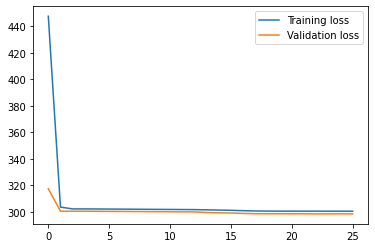

In [42]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [43]:
model.evaluate(X_test, y_test)

114555/114555 [==============================] - 364s 3ms/step - loss: 372.5155


372.5154724121094

Reconstruction error threshold: 431.1930633544922


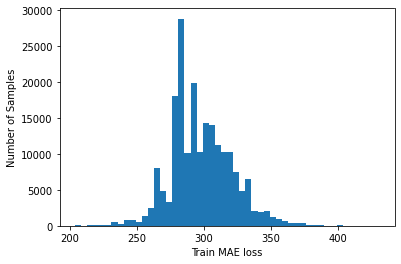

In [44]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

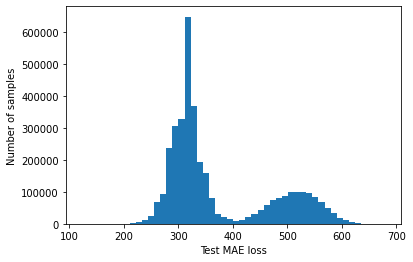

In [45]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [50]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['ID'] = test[TIME_STEPS:]['ID']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Timestamp'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Timestamp'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [47]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(1047069, 6)

## True Positive & True Negative

In [60]:
TP=len(test_score_df.loc[(test_score_df['label']=='T') & test_score_df['anomaly']])

In [61]:
TN=len(test_score_df.loc[(test_score_df['label']=='R') & ~test_score_df['anomaly']])

## False Positive & False Negative

In [62]:
FP=len(test_score_df.loc[(test_score_df['label']=='R') & test_score_df['anomaly']])

In [63]:
FN=len(test_score_df.loc[(test_score_df['label']=='T') & ~test_score_df['anomaly']])

## Result


### Accuracy

In [65]:
(TP+TN)/(FP+FN+TP+TN)

0.8632773357560003

Not Bad... but 0.86 is little bit high  
Threshold is 431 in this case.  
Try with time step 100. It would decrease variance in Train MAE loss.



## time step 100

In [67]:
TIME_STEPS=100

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):

        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

In [68]:
X_train, y_train = create_sequences(train[['ID']][:200000], train['ID'][:200000])
print(f'Training shape: {X_train.shape}')

Training shape: (199900, 100, 1)


In [69]:
X_test, y_test = create_sequences(test[['ID']], test['ID'])
print(f'Testing shape: {X_test.shape}')

Testing shape: (3665670, 100, 1)


In [70]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_4 (RepeatVect  (None, 100, 128)         0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 100, 128)          131584    
                                                                 
 dropout_9 (Dropout)         (None, 100, 128)          0         
                                                                 
 time_distributed_4 (TimeDis  (None, 100, 1)           129       
 tributed)                                            

In [71]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
5623/5623 [==============================] - 85s 15ms/step - loss: 446.6535 - val_loss: 316.2563
Epoch 2/100
5623/5623 [==============================] - 83s 15ms/step - loss: 302.1426 - val_loss: 298.6717
Epoch 3/100
5623/5623 [==============================] - 82s 15ms/step - loss: 300.7752 - val_loss: 298.6669
Epoch 4/100
5623/5623 [==============================] - 84s 15ms/step - loss: 300.7663 - val_loss: 298.6679
Epoch 5/100
5623/5623 [==============================] - 84s 15ms/step - loss: 300.7615 - val_loss: 298.6678
Epoch 6/100
5623/5623 [==============================] - 84s 15ms/step - loss: 300.7552 - val_loss: 298.6834


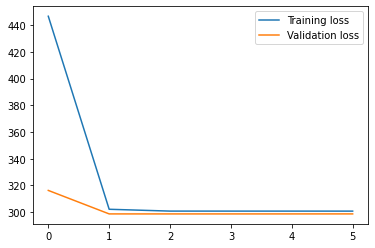

In [72]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [73]:
model.evaluate(X_test, y_test)

114553/114553 [==============================] - 701s 6ms/step - loss: 375.4410


375.4410095214844

Reconstruction error threshold: 329.9081457519531


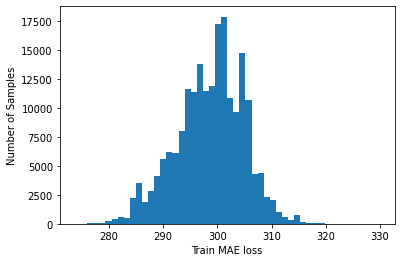

In [75]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

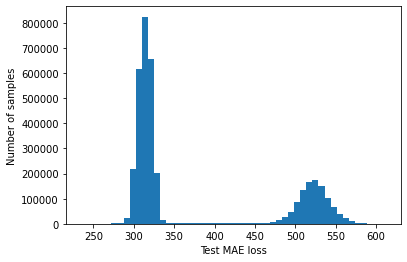

In [76]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [77]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['ID'] = test[TIME_STEPS:]['ID']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Timestamp'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Timestamp'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [78]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(1146752, 6)

## True Positive & True Negative

In [79]:
TP=len(test_score_df.loc[(test_score_df['label']=='T') & test_score_df['anomaly']])

In [80]:
TN=len(test_score_df.loc[(test_score_df['label']=='R') & ~test_score_df['anomaly']])

### False Positive & False Negative

In [81]:
FP=len(test_score_df.loc[(test_score_df['label']=='R') & test_score_df['anomaly']])

In [82]:
FN=len(test_score_df.loc[(test_score_df['label']=='T') & ~test_score_df['anomaly']])

## Result

### Accuracy

In [83]:
(TP+TN)/(TP+TN+FP+FN)

0.8464271259488626

Accuracy decreased. In my opinion, time step was too high for detecting granular changes.   
Maybe should try time step less than 20 and time step between 20 and 100(maybe 50).

## Time step 10

In [12]:
TIME_STEPS=10

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):

        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

In [13]:
X_train, y_train = create_sequences(train[['ID']][:200000], train['ID'][:200000])
print(f'Training shape: {X_train.shape}')

Training shape: (199990, 10, 1)


In [14]:
X_test, y_test = create_sequences(test[['ID']], test['ID'])
print(f'Testing shape: {X_test.shape}')

Testing shape: (3665760, 10, 1)


In [15]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 10, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 10, 1)            129       
 ibuted)                                                

In [16]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
5625/5625 [==============================] - 41s 6ms/step - loss: 448.2632 - val_loss: 318.4937
Epoch 2/100
5625/5625 [==============================] - 32s 6ms/step - loss: 305.1842 - val_loss: 302.5700
Epoch 3/100
5625/5625 [==============================] - 32s 6ms/step - loss: 303.8634 - val_loss: 302.5663
Epoch 4/100
5625/5625 [==============================] - 32s 6ms/step - loss: 303.8500 - val_loss: 302.5710
Epoch 5/100
5625/5625 [==============================] - 32s 6ms/step - loss: 303.8414 - val_loss: 302.5616
Epoch 6/100
5625/5625 [==============================] - 32s 6ms/step - loss: 303.8360 - val_loss: 302.5551
Epoch 7/100
5625/5625 [==============================] - 32s 6ms/step - loss: 303.8320 - val_loss: 302.5472
Epoch 8/100
5625/5625 [==============================] - 32s 6ms/step - loss: 303.8235 - val_loss: 302.5446
Epoch 9/100
5625/5625 [==============================] - 32s 6ms/step - loss: 303.8113 - val_loss: 302.5249
Epoch 10/100
5625/5625 [====

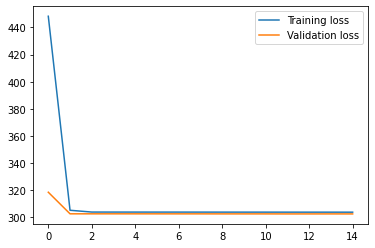

In [17]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [18]:
model.evaluate(X_test, y_test)

114555/114555 [==============================] - 329s 3ms/step - loss: 377.0321


377.0321350097656

Reconstruction error threshold: 558.9774780273438


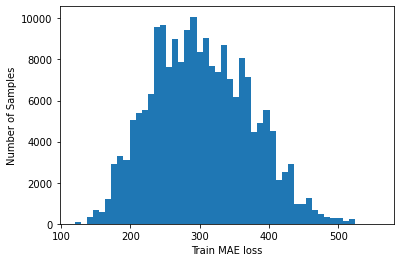

In [19]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

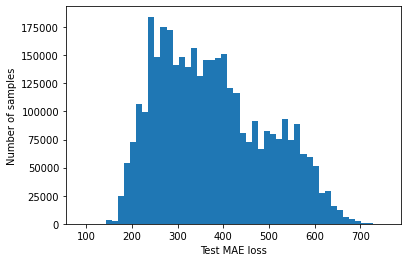

In [20]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [ ]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['ID'] = test[TIME_STEPS:]['ID']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Timestamp'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Timestamp'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [ ]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

### Result

In [23]:
TP=len(test_score_df.loc[(test_score_df['label']=='T') & test_score_df['anomaly']])

In [24]:
TN=len(test_score_df.loc[(test_score_df['label']=='R') & ~test_score_df['anomaly']])

In [25]:
FP=len(test_score_df.loc[(test_score_df['label']=='R') & test_score_df['anomaly']])

In [26]:
FN=len(test_score_df.loc[(test_score_df['label']=='T') & ~test_score_df['anomaly']])

### Accuracy

In [27]:
(TP+TN)/(TP+TN+FP+FN)

0.8393758604864617